AlexNet je arhitektura konvolucionih neuronskih mreža iz 2014 namenjena za klasifikaciju slika na 1000 kategorija. Za svoj problem imala je preciznost od 84%.

Iako model ove veličine nije potreban za rešavanje ovog problema, ideja je testirati poznate modele.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Reshape, GaussianNoise, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
data_dir = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/scaled"

In [3]:
def load_images_to_numpy(src_path: str) -> np.ndarray:
    res = os.listdir(src_path)
    res = map(lambda path: os.path.join(src_path, path), res)
    res = map(Image.open, res)
    res = map(np.asarray, res)
    res = np.stack([*res], axis=0)
    return res

def load_images(src_path: str):
    X_false = load_images_to_numpy(os.path.join(src_path, "NORMAL"))
    y_false = np.zeros((X_false.shape[0],), dtype=np.uint8)

    X_true = load_images_to_numpy(os.path.join(src_path, "PNEUMONIA"))
    y_true = np.ones((X_true.shape[0],), dtype=np.uint8)

    X = np.concatenate([X_false, X_true])
    y = np.concatenate([y_false, y_true])
    return (X, y)

In [4]:
X, y = load_images(os.path.join(data_dir, "train"))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [6]:
def make_model(shape, activation, **kwargs):
    model = Sequential()

    model.add(InputLayer(shape))
    model.add(Reshape((shape[0], shape[1], 1)))

    model.add(Conv2D(96, (11, 11), strides = (4,4), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides = (2,2)))

    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides = (2,2)))

    model.add(Conv2D(384, (3, 3), activation='relu'))
    model.add(Conv2D(384, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides = (2,2)))

    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))

    model.add(Dense(1, activation=activation))

    model.compile(**kwargs)
    return model

In [16]:
model = make_model(
  shape=(X_train.shape[1], X_train.shape[2]),
  activation='sigmoid',
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 280, 400, 1)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 68, 98, 96)        11712     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 33, 48, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 44, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 21, 256)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 19, 384)      

Zbog veličine modela moraće duže da se trenira

In [18]:
model_path = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/models/alexnet"
if not os.path.isdir(model_path):
        os.makedirs(model_path)

In [19]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[
        ModelCheckpoint(
          filepath=os.path.join(model_path, "model.h5"),
          save_best_only=True,
          monitor='val_loss',
          mode='min'
        )
    ]
)

Epoch 1/100
132/132 [==============================] - 15s 96ms/step - loss: 4.4935 - accuracy: 0.7661 - val_loss: 0.2922 - val_accuracy: 0.8745
Epoch 2/100
132/132 [==============================] - 3s 22ms/step - loss: 0.4148 - accuracy: 0.8478 - val_loss: 0.3474 - val_accuracy: 0.8809
Epoch 3/100
132/132 [==============================] - 8s 62ms/step - loss: 0.3600 - accuracy: 0.8660 - val_loss: 0.2910 - val_accuracy: 0.8979
Epoch 4/100
132/132 [==============================] - 3s 21ms/step - loss: 0.3202 - accuracy: 0.8786 - val_loss: 0.3060 - val_accuracy: 0.8809
Epoch 5/100
132/132 [==============================] - 8s 61ms/step - loss: 0.3103 - accuracy: 0.8887 - val_loss: 0.2091 - val_accuracy: 0.9128
Epoch 6/100
132/132 [==============================] - 3s 21ms/step - loss: 0.2722 - accuracy: 0.9010 - val_loss: 0.3704 - val_accuracy: 0.8596
Epoch 7/100
132/132 [==============================] - 3s 21ms/step - loss: 0.3722 - accuracy: 0.8679 - val_loss: 0.2568 - val_accuracy

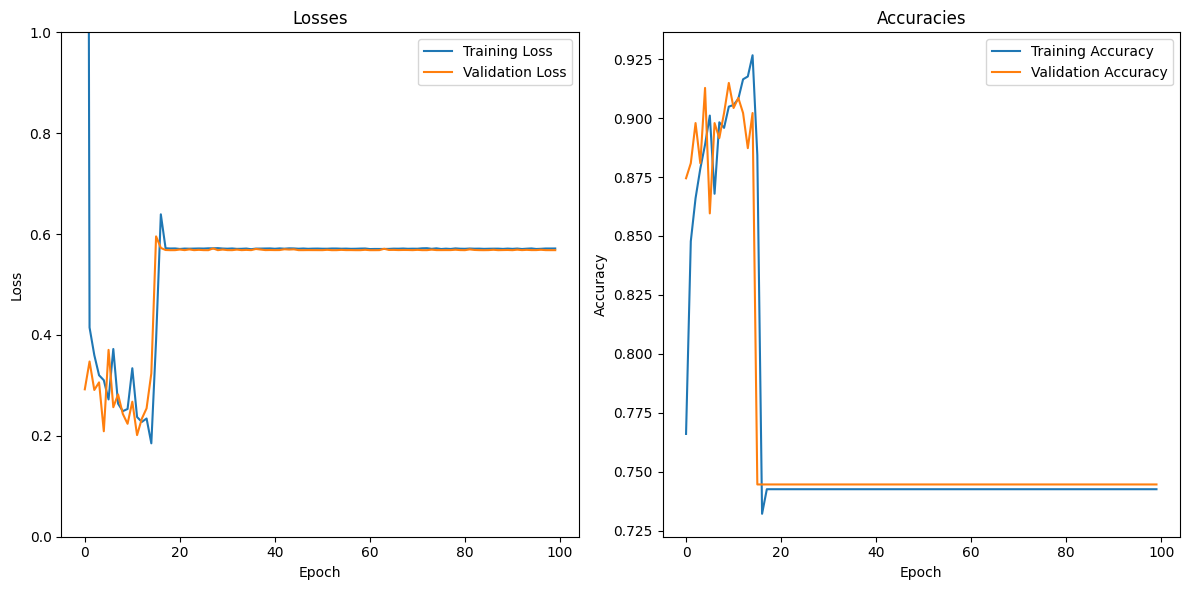

In [20]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

Malopre napravljeni modeli rade drastično bolje, ali će ovaj svakako biti sačuvan

In [21]:
best_model = load_model(os.path.join(model_path, "model.h5"))

In [22]:
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred < 0.5, 0, 1)

17/17 [==============================] - 1s 46ms/step


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       134
           1       0.94      0.91      0.93       388

    accuracy                           0.89       522
   macro avg       0.85      0.87      0.86       522
weighted avg       0.90      0.89      0.89       522



In [24]:
pd.DataFrame(confusion_matrix(y_test, y_pred), index=["NORMAL", "PNEUMONIA"], columns=["NORMAL", "PNEUMONIA"])

,NORMAL,PNEUMONIA
NORMAL,111,23
PNEUMONIA,33,355
